<a href="https://colab.research.google.com/github/MRaynardAlif/EmotionAnalisysBERT_Indonesia/blob/main/EmotionAnalisysBert20523167.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00


In [ ]:
import gdown
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

#Mengunduh dataset
url = 'https://drive.google.com/uc?id=1WkvRVTd52OrJY8fxNd9YVA6cptYWoPCl'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)

#Membaca dataset
df = pd.read_csv('dataset.csv')

#Menyiapkan label dan teks dari dataset
labels = df['label'].tolist()
texts = df['tweet'].tolist()

label_mapping = {'fear': 0, 'happy': 1, 'sadness': 2, 'anger': 3, 'love': 4}
labels = df['label'].map(label_mapping).tolist()


#Menginisialisasi tokenizer BERT bahasa Indonesia
tokenizer = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M', do_lower_case=True)

#Melakukan tokenisasi dan encoding pada teks
encoded_inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

#Membuat dataset PyTorch
dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'], torch.tensor(labels))

#Membuat dataloader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#Membangun model BERT untuk klasifikasi emosi
model = BertForSequenceClassification.from_pretrained('cahya/bert-base-indonesian-522M', num_labels=5)

#Menggunakan GPU jika tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#Fungsi evaluasi
def evaluate(model, dataloader):
    model.eval()
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted_labels = torch.max(outputs.logits, dim=1)

            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

    accuracy = correct_predictions / total_samples
    return accuracy

# Melakukan fine-tuning pada model
optimizer = AdamW(model.parameters(), lr=2e-5)
lambda_penalty = 0.001  # Memberikan penalti untuk mengatasi overfitting
epochs = 5

train_losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0

    for batch in dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss + lambda_penalty * torch.norm(torch.cat([p.view(-1) for p in model.parameters()]), 2)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted_labels = torch.max(outputs.logits, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    train_losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f'Epoch {epoch+1}: Average Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')


Downloading...
From: https://drive.google.com/uc?id=1WkvRVTd52OrJY8fxNd9YVA6cptYWoPCl
To: /content/dataset.csv
100%|██████████| 841k/841k [00:00<00:00, 135MB/s]


Some weights of the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-ba

Epoch 1: Average Loss = 1.4287, Accuracy = 0.5496
Epoch 2: Average Loss = 1.0001, Accuracy = 0.7441
Epoch 3: Average Loss = 0.6946, Accuracy = 0.8689
Epoch 4: Average Loss = 0.4733, Accuracy = 0.9498
Epoch 5: Average Loss = 0.3931, Accuracy = 0.9750


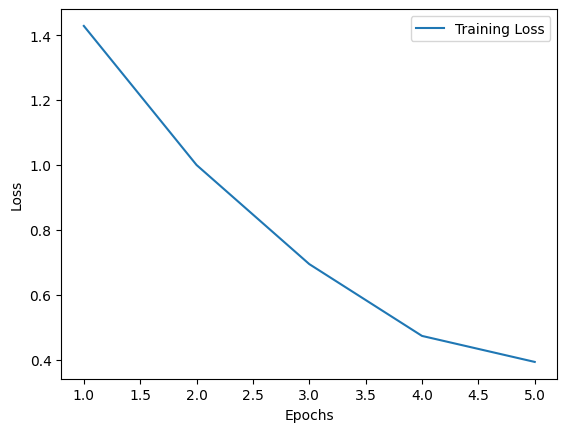

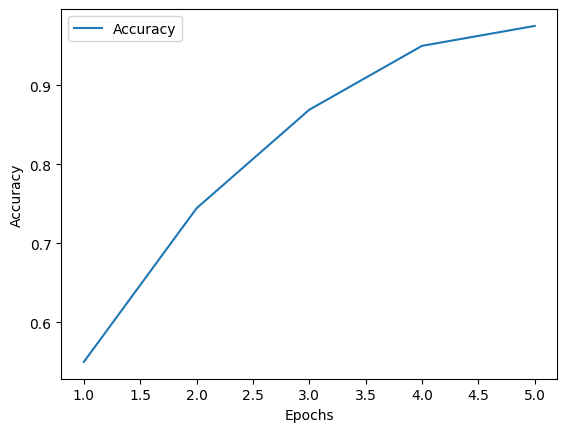

In [ ]:
import matplotlib.pyplot as plt

# Menampilkan grafik loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Menampilkan grafik akurasi
plt.plot(range(1, epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


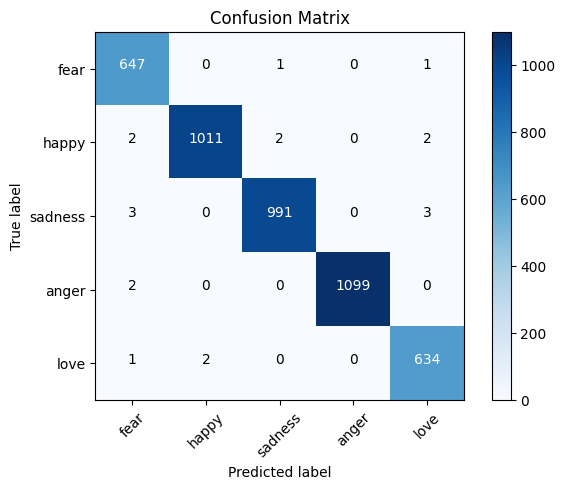

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Setelah pelatihan selesai, lakukan evaluasi pada data uji
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, predicted_labels = torch.max(outputs.logits, dim=1)

        y_true.extend(labels.tolist())
        y_pred.extend(predicted_labels.tolist())

# Mengubah label menjadi array NumPy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Mendapatkan confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix
classes = ['fear', 'happy', 'sadness', 'anger', 'love']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate confusion matrix dengan nilai di dalam sel
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
#Menguji model dengan input baru
new_text = "Kampusnya oke, tp attitude mahasiswanya kurang ya"
inputs = tokenizer.encode_plus(new_text, padding=True, truncation=True, max_length=512, return_tensors='pt')
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    _, predicted_label = torch.max(outputs.logits, dim=1)

predicted_emotion = predicted_label.item()
label_mapping = {0: 'fear', 1: 'happy', 2: 'sadness', 3: 'anger', 4: 'love'}
predicted_emotion_label = label_mapping[predicted_emotion]

print(f'Predicted Emotion: {predicted_emotion_label}')

Predicted Emotion: sadness
